In [33]:
import torch
import torch.nn as nn
import torch.optim
import torchvision
import torchvision.transforms.v2 as v2
import torchvision.datasets
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

import random

from tqdm import tqdm

torch.Size([1, 32, 32])


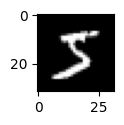

In [3]:
transform = v2.Compose([
    v2.Pad(2),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.5], std=[0.5]),
])

train_dataset = torchvision.datasets.MNIST(root='./dataset', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./dataset', train=False, transform=transform, download=True)

x, y = train_dataset[0]
print(x.shape)
x = x.squeeze(0)
plt.figure(figsize=(1,1))
plt.imshow(x, cmap='grey')
plt.show()

In [4]:
class Ebm(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.activation = nn.SiLU()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=2, padding=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.flatten = nn.Flatten()
        self.dense = nn.Linear(in_features=64, out_features=1)

    def forward(self, x):
        out = self.conv1(x)
        out = self.activation(out)
        
        out = self.conv2(out)
        out = self.activation(out)

        out = self.conv3(out)
        out = self.activation(out)

        out = self.conv4(out)
        out = self.activation(out)

        out = self.conv5(out)
        out = self.activation(out)

        out = self.flatten(out)
        out = self.dense(out)
        out = self.activation(out)

        return out

model = Ebm()
sample = train_dataset[0][0].unsqueeze(0)
print(sample.shape)
out = model(sample)
print(out.shape)
print(out)


torch.Size([1, 1, 32, 32])
torch.Size([1, 1])
tensor([[0.0331]], grad_fn=<SiluBackward0>)


In [101]:
def generate_samples(model, inp_imgs, steps, step_size, noise):
    imgs_per_step = []
    for _ in range(steps):
        # add noise
        inp_imgs += torch.randn(inp_imgs.shape, device=inp_imgs.device) * noise # noise : stddev
        inp_imgs = torch.clip(inp_imgs, min=-1.0, max=1.0)
        
        # get energy score
        out_score = -model(inp_imgs)

        # calculate gradiant
        grads = torch.autograd.grad(
            outputs=out_score, 
            inputs=inp_imgs, 
            retain_graph=True,
            grad_outputs=torch.ones_like(out_score))[0]
    
        grads = torch.clip(grads, min=-0.03, max=0.03)

        # add gradiant to image
        inp_imgs += -step_size * grads
        inp_imgs = torch.clip(inp_imgs, min=-1.0, max=1.0)
        imgs_per_step.append(inp_imgs)

    return inp_imgs, imgs_per_step


In [102]:
# Generating samples from model to train
class Buffer:
    def __init__(self, model, batch_size, device) -> None:
        super().__init__()
        self.model = model
        self.batch_size = batch_size
        self.device = device
        self.examples = [
            torch.rand([1, 1,32,32], device=device) * 2 - 1 for _ in range(batch_size)
        ]
    
    def sample_new_exmps(self, steps, step_size, noise):
        n_new = np.random.binomial(self.batch_size, 0.05)
        rand_imgs = (
            torch.rand([n_new, 1, 32,32], requires_grad=True, device=device) * 2 - 1
        )
        choice_d = random.choices(self.examples, k=(self.batch_size - n_new))
        old_imgs = torch.cat(
            choice_d, dim=0
        )
        inp_imgs = torch.cat([rand_imgs, old_imgs], dim=0)
        inp_imgs = inp_imgs.to(device)
        inp_imgs, _ = generate_samples(
            self.model, inp_imgs, steps, step_size, noise
        )
        self.examples = list(torch.split(inp_imgs, 1, dim=0))  + self.examples
        self.examples = self.examples[:8192]
        return inp_imgs

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
buffer = Buffer(model, 16, device)
res = buffer.sample_new_exmps(steps=60, step_size=10, noise=0.005)
print(res.shape)
    

torch.Size([16, 1, 32, 32])


In [104]:
def train(model, buffer, optimizer, n_epoch, dataloader, device):
    pbar = tqdm(dataloader)
    loss_history = []
    model.train()
    for epoch in range(n_epoch):
        loss_sum = 0
        n_total = 0 
        for _, (x, _) in enumerate(pbar):
            optimizer.zero_grad()
            # add random noise to data to prevent overfitting
            x += torch.randn_like(x) * 0.005 # 0.005 is stddev
            x = torch.clip(x, -1.0, 1.0)
            x = x.to(device)
            
            # get samples from buffer
            fake_imgs = buffer.sample_new_exmps(steps=60, step_size=10, noise=0.005)
            inp_imgs = torch.concat([x, fake_imgs], dim = 0)
            real_out, fake_out = torch.vsplit(model(inp_imgs), 2)

            # loss : -(\nabla model(x_train) - \nabla model(x_sample))
            contrastive_divergence_loss = -(
                torch.mean(real_out, dim=0) # x_train
                - torch.mean(fake_out, dim = 0) #x_sample
                )
            
            loss_sum += contrastive_divergence_loss.item() * x.shape[0]
            n_total += x.shape[1] 
                    
            pbar.set_postfix_str(f"[{epoch}] loss:{contrastive_divergence_loss.item():.5f}")
            contrastive_divergence_loss.backward()
            optimizer.step()
        
        epoch_loss = loss_sum / n_total
        loss_history.append(epoch_loss)
    
    return loss_history

device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 128

model = model.to(device)
buffer = Buffer(model, batch_size, device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
dl = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
loss_history = train(model, buffer, optimizer, 50, dl, device)

  0%|          | 1/469 [00:00<02:57,  2.64it/s, [0] loss:-0.00587]


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.